In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
medical_df = pd.read_csv('medical.csv')

In [ ]:
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [ ]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Correlation

As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [ ]:
medical_df.charges.corr(medical_df.age)

0.2990081933306476

In [ ]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362895

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [ ]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.charges.corr(smoker_numeric)

0.787251430498478

* **Strength**: The greater the absolute value of the correlation coefficient, the stronger the relationship.

    * The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.

    * A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.
    
    * When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.


* **Direction**: The sign of the correlation coefficient represents the direction of the relationship.

    * Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.
    
    * Negative coefficients represent cases when the value of one variable increases, the value of the other variable tends to decrease. Negative relationships produce a downward slope.

Here's the same relationship expressed visually ([source](https://www.cuemath.com/data/how-to-calculate-correlation-coefficient/)):

<img src="https://i.imgur.com/3XUpDlw.png" width="360">

The correlation coefficient has the following formula:

<img src="https://i.imgur.com/unapugP.png" width="360">

You can learn more about the mathematical definition and geometric interpretation of correlation here: https://www.youtube.com/watch?v=xZ_z8KWkhXE

Pandas dataframes also provide a `.corr` method to compute the correlation coefficients between all pairs of numeric columns.

In [ ]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


The result of `.corr` is called a correlation matrix and is often visualized using a heatmap.

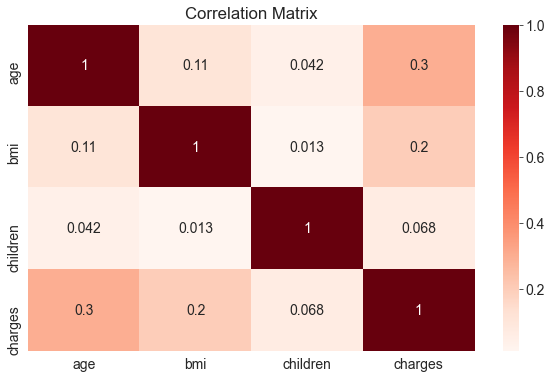

In [ ]:
sns.heatmap(medical_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

In [ ]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

Next, let's visualize the relationship between "age" and "charges"

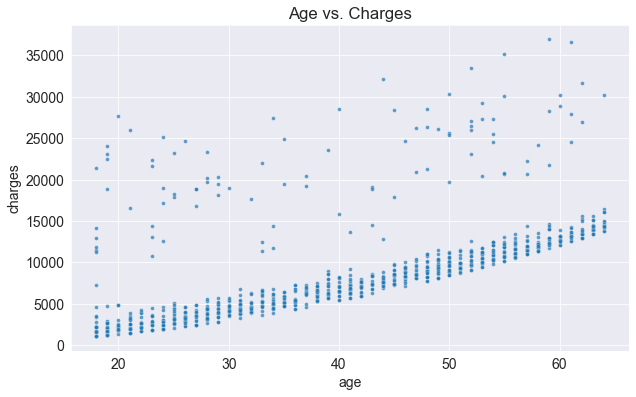

In [ ]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15);

Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula:

$y = wx + b$

The line is characterized two numbers: $w$ (called "slope") and $b$ (called "intercept").

### Model

In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assuming the following relationship between the two:

$charges = w \times age + b$

We'll try determine $w$ and $b$ for the line that best fits the data.

* This technique is called _linear regression_, and we call the above equation a _linear regression model_, because it models the relationship between "age" and "charges" as a straight line.

* The numbers $w$ and $b$ are called the _parameters_ or _weights_ of the model.

* The values in the "age" column of the dataset are called the _inputs_ to the model and the values in the charges column are called "targets".

Let define a helper function `estimate_charges`, to compute $charges$, given $age$, $w$ and $b$.


In [ ]:
def estimate_charges(age, w, b):
    return w * age + b

The `estimate_charges` function is our very first _model_.

Let's _guess_ the values for $w$ and $b$ and use them to estimate the value for charges.

In [ ]:
w = 50
b = 100

In [ ]:
ages = non_smoker_df.age
estimated_charges = estimate_charges(ages, w, b)

We can plot the estimated charges using a line graph.

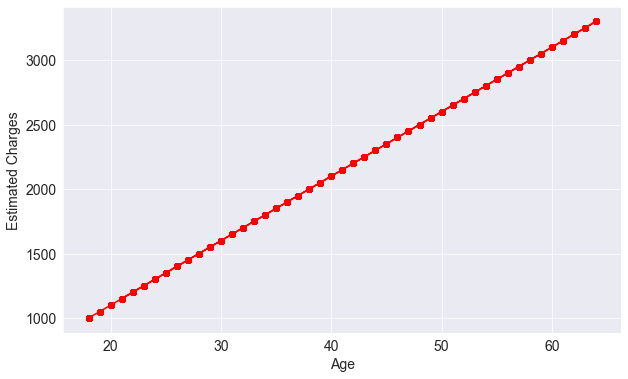

In [ ]:
plt.plot(ages, estimated_charges, 'r-o');
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

As expected, the points lie on a straight line.

We can overlay this line on the actual data, so see how well our _model_ fits the _data_.

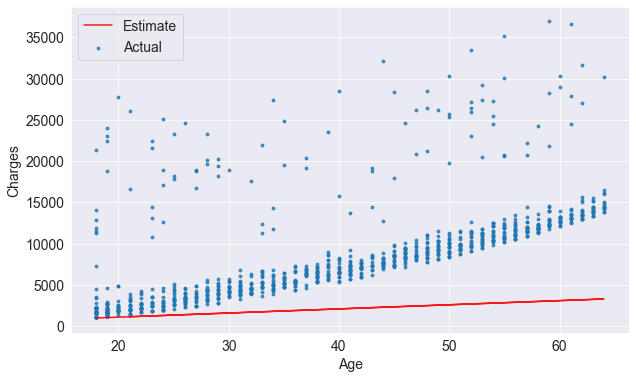

In [ ]:
target = non_smoker_df.charges

plt.plot(ages, estimated_charges, 'r', alpha=0.9);
plt.scatter(ages, target, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual']);

Clearly, the our estimates are quite poor and the line does not "fit" the data. However, we can try different values of $w$ and $b$ to move the line around. Let's define a helper function `try_parameters` which takes `w` and `b` as inputs and creates the above plot.

In [ ]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges

    estimated_charges = estimate_charges(ages, w, b)

    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual']);

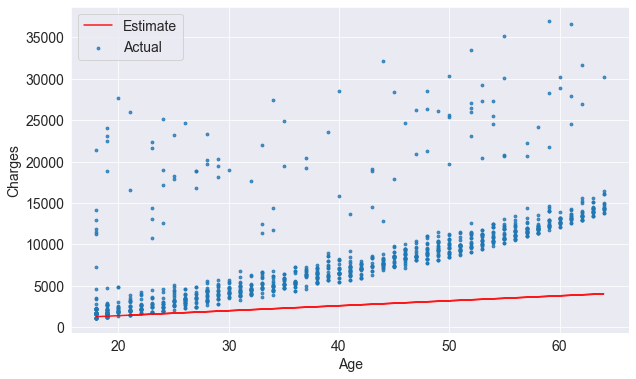

In [ ]:
try_parameters(60, 200)

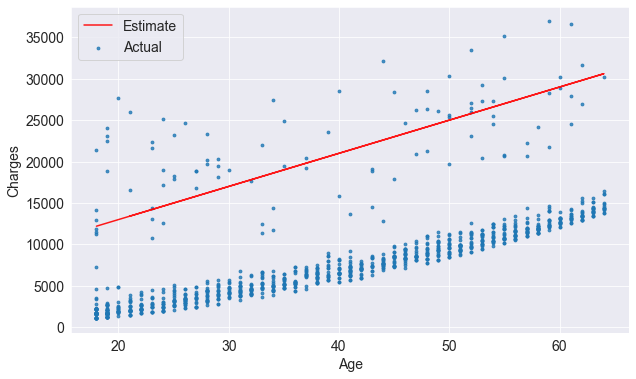

In [ ]:
try_parameters(400, 5000)

### Loss/Cost Function

We can compare our model's predictions with the actual targets using the following method:

* Calculate the difference between the targets and predictions (the differenced is called the "residual")
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.
* Take the square root of the result

The result is a single number, known as the **root mean squared error** (RMSE). The above description can be stated mathematically as follows:

<img src="https://i.imgur.com/WCanPkA.png" width="360">

Geometrically, the residuals can be visualized as follows:

<img src="https://i.imgur.com/ll3NL80.png" width="420">

Let's define a function to compute the RMSE.

In [ ]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

Let's compute the RMSE for our model with a sample set of weights

In [ ]:
w = 50
b = 100

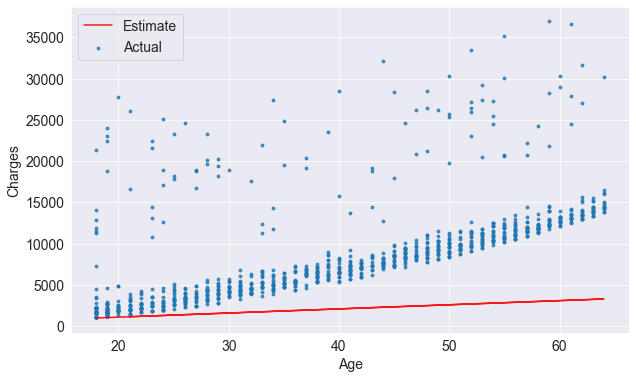

In [ ]:
try_parameters(w, b)

In [ ]:
targets = non_smoker_df['charges']
predicted = estimate_charges(non_smoker_df.age, w, b)

In [ ]:
rmse(targets, predicted)

8461.949562575493

Here's how we can interpret the above number: *On average, each element in the prediction differs from the actual target by \\$8461*.

The result is called the *loss* because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

Let's modify the `try_parameters` functions to also display the loss.

In [ ]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    predictions = estimate_charges(ages, w, b)

    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual']);

    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  8461.949562575493


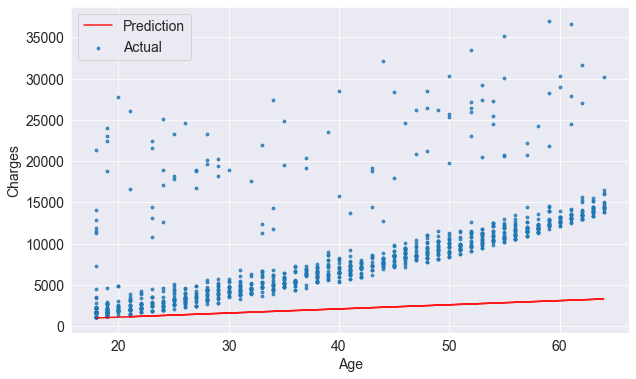

In [ ]:
try_parameters(50, 100)

### Optimizer

Next, we need a strategy to modify weights `w` and `b` to reduce the loss and improve the "fit" of the line to the data.

* Ordinary Least Squares: https://www.youtube.com/watch?v=szXbuO3bVRk (better for smaller datasets)
* Stochastic gradient descent: https://www.youtube.com/watch?v=sDv4f4s2SB8 (better for larger datasets)

Both of these have the same objective: to minimize the loss, however, while ordinary least squares directly computes the best values for `w` and `b` using matrix operations, while gradient descent uses a iterative approach, starting with a random values of `w` and `b` and slowly improving them using derivatives.

Here's a visualization of how gradient descent works:

![](https://miro.medium.com/max/1728/1*NO-YvpHHadk5lLxtg4Gfrw.gif)

Doesn't it look similar to our own strategy of gradually moving the line closer to the points?



### Linear Regression using Scikit-learn

In practice, you'll never need to implement either of the above methods yourself. You can use a library like `scikit-learn` to do this for you.

Let's use the `LinearRegression` class from `scikit-learn` to find the best fit line for "age" vs. "charges" using the ordinary least squares optimization technique.

In [ ]:
from sklearn.linear_model import LinearRegression

First, we create a new model object.

In [ ]:
model = LinearRegression()

Next, we can use the `fit` method of the model to find the best fit line for the inputs and targets.

In [ ]:
help(model.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data
    
    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary
    
    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : returns an instance of self.



Not that the input `X` must be a 2-d array, so we'll need to pass a dataframe, instead of a single column.

In [ ]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.charges
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


Let's fit the model to the data.

In [ ]:
model.fit(inputs, targets)

LinearRegression()

We can now make predictions using the model. Let's try predicting the charges for the ages 23, 37 and 61

In [ ]:
model.predict(np.array([[23],
                        [37],
                        [61]]))

array([ 4055.30443855,  7796.78921819, 14210.76312614])

Do these values seem reasonable? Compare them with the scatter plot above.

Let compute the predictions for the entire set of inputs

In [ ]:
predictions = model.predict(inputs)

In [ ]:
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

Let's compute the RMSE loss to evaluate the model.

In [ ]:
rmse(targets, predictions)

4662.505766636395

Seems like our prediction is off by $4000 on average, which is not too bad considering the fact that there are several outliers.

The parameters of the model are stored in the `coef_` and `intercept_` properties.

In [ ]:
# w
model.coef_

array([267.24891283])

In [ ]:
# b
model.intercept_

-2091.4205565650864

Are these parameters close to your best guesses?

Let's visualize the line created by the above parameters.

RMSE Loss:  4662.505766636395


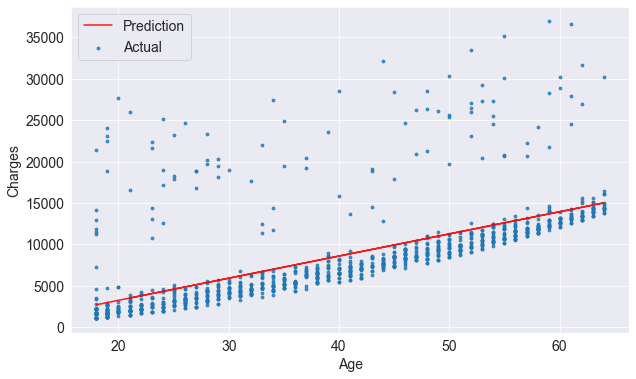

In [ ]:
try_parameters(model.coef_, model.intercept_)

### Machine Learning

Congratulations, you've just trained your first _machine learning model!_ Machine learning is simply the process of computing the best parameters to model the relationship between some feature and targets.

Every machine learning problem has three components:

1. **Model**

2. **Cost Function**

3. **Optimizer**

We'll look at several examples of each of the above in future tutorials. Here's how the relationship between these three components can be visualized:

<img src="https://i.imgur.com/oiGQFJ9.png" width="480">

As we've seen above, it takes just a few lines of code to train a machine learning model using `scikit-learn`.

In [ ]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.505766636395


## Linear Regression using Multiple Features

So far, we've used on the "age" feature to estimate "charges". Adding another feature like "bmi" is fairly straightforward. We simply assume the following relationship:

$charges = w_1 \times age + w_2 \times bmi + b$

We need to change just one line of code to include the BMI.

In [ ]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.3128354612945


As you can see, adding the BMI doesn't seem to reduce the loss by much, as the BMI has a very weak correlation with charges, especially for non smokers.

In [ ]:
non_smoker_df.charges.corr(non_smoker_df.bmi)

0.08403654312833268

In [ ]:
model.coef_, model.intercept_

(array([266.87657817,   7.07547666]), -2293.6320906488727)

Clearly, BMI has a much lower weightage, and you can see why. It has a tiny contribution, and even that is probably accidental. This is an important thing to keep in mind: you can't find a relationship that doesn't exist, no matter what machine learning technique or optimization algorithm you apply.

In [ ]:
non_smoker_df.charges.corr(non_smoker_df.children)

0.13892870453542194

In [ ]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi', 'children']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4608.470405038246


In [ ]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children']], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 11355.317901125973


## Using Categorical Features for Machine Learning

So far we've been using only numeric columns, since we can only perform computations with numbers. If we could use categorical columns like "smoker", we can train a single model for the entire dataset.

To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

1. If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.
2. If a categorical column has more than 2 categories, we can perform one-hot encoding i.e. create a new column for each category with 1s and 0s.
3. If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals




## Binary Categories

The "smoker" category has just two values "yes" and "no". Let's create a new column "smoker_code" containing 0 for "no" and 1 for "yes".


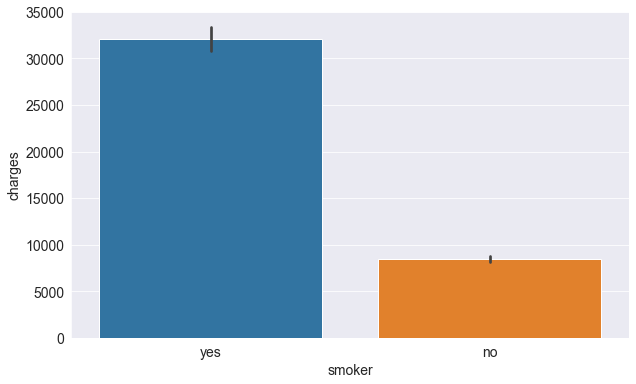

In [ ]:
sns.barplot(data=medical_df, x='smoker', y='charges');

In [ ]:
smoker_codes = {'no': 0, 'yes': 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_codes)

In [ ]:
medical_df.charges.corr(medical_df.smoker_code)

0.787251430498478

In [ ]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0
1334,18,female,31.920,0,no,northeast,2205.98080,0
1335,18,female,36.850,0,no,southeast,1629.83350,0
1336,21,female,25.800,0,no,southwest,2007.94500,0


We can now use the `smoker_df` column for linear regression.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + b$

In [ ]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code']], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.439217188081


The loss reduces from `11355` to `6056`, almost by 50%! This is an important lesson: never ignore categorical data.


Let's try adding the "sex" column as well.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + b$

<AxesSubplot:xlabel='sex', ylabel='charges'>

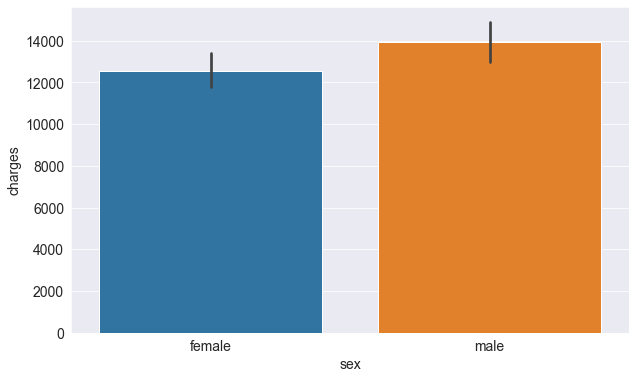

In [ ]:
sns.barplot(data=medical_df, x='sex', y='charges')

In [ ]:
sex_codes = {'female': 0, 'male': 1}

In [ ]:
medical_df['sex_code'] = medical_df.sex.map(sex_codes)

In [ ]:
medical_df.charges.corr(medical_df.sex_code)

0.057292062202025484

In [ ]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code', 'sex_code']], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.100708754546


As you might expect, this does have a significant impact on the loss.


### One-hot Encoding

The "region" column contains 4 values, so we'll need to use hot encoding and create a new column for each region.

![](https://i.imgur.com/n8GuiOO.png)


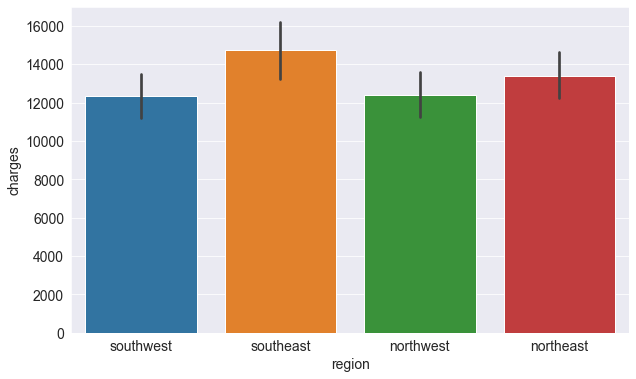

In [ ]:
sns.barplot(data=medical_df, x='region', y='charges');

In [ ]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['region']])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [ ]:
one_hot = enc.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [ ]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [ ]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


Let's include the region columns into our linear regression model.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

In [ ]:
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = medical_df[input_cols], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


Once again, this leads to a fairly small reduction in the loss.

> **EXERCISE**: Are two separate linear regression models, one for smokers and one of non-smokers, better than a single linear regression model? Why or why not? Try it out and see if you can justify your answer with data.

Let's save our work before continuing.

In [ ]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "aakashns/python-sklearn-linear-regression" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/aakashns/python-sklearn-linear-regression


'https://jovian.ai/aakashns/python-sklearn-linear-regression'

## Model Improvements

Let's discuss and apply some more improvements to our model.

### Feature Scaling

Recall that due to regulatory requirements, we also need to explain the rationale behind the predictions our model.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

To compare the importance of each feature in the model, our first instinct might be to compare their weights.

In [ ]:
model.coef_

array([  256.85635254,   339.19345361,   475.50054515, 23848.53454191,
        -131.3143594 ,   587.00923503,   234.0453356 ,  -448.01281436,
        -373.04175627])

In [ ]:
model.intercept_

-12525.547811195444

In [ ]:
weights_df = pd.DataFrame({
    'feature': np.append(input_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df

,feature,weight
0,age,256.856353
1,bmi,339.193454
2,children,475.500545
3,smoker_code,23848.534542
4,sex_code,-131.314359
5,northeast,587.009235
6,northwest,234.045336
7,southeast,-448.012814
8,southwest,-373.041756
9,1,-12525.547811


While it seems like BMI and the "northeast" have a higher weight than age, keep in mind that the range of values for BMI is limited (15 to 40) and the "northeast" column only takes the values 0 and 1.

Because different columns have different ranges, we run into two issues:

1. We can't compare the weights of different column to identify which features are important
2. A column with a larger range of inputs may disproportionately affect the loss and dominate the optimization process.

For this reason, it's common practice to scale (or standardize) the values in numeric column by subtracting the mean and dividing by the standard deviation.

![](https://i.imgur.com/dT5fLFI.png)

We can apply scaling using the StandardScaler class from `scikit-learn`.

In [ ]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
numeric_cols = ['age', 'bmi', 'children']
scaler = StandardScaler()
scaler.fit(medical_df[numeric_cols])

StandardScaler()

In [ ]:
scaler.mean_

array([39.20702541, 30.66339686,  1.09491779])

In [ ]:
scaler.var_

array([197.25385199,  37.16008997,   1.45212664])

We can now scale data as follows:

In [ ]:
scaled_inputs = scaler.transform(medical_df[numeric_cols])
scaled_inputs

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

These can now we combined with the categorical data

In [ ]:
cat_cols = ['smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
categorical_data = medical_df[cat_cols].values

In [ ]:
inputs = np.concatenate((scaled_inputs, categorical_data), axis=1)
targets = medical_df.charges

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


We can now compare the weights in the formula:

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

In [ ]:
weights_df = pd.DataFrame({
    'feature': np.append(numeric_cols + cat_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df.sort_values('weight', ascending=False)

,feature,weight
3,smoker_code,23848.534542
9,1,8466.483215
0,age,3607.472736
1,bmi,2067.691966
5,northeast,587.009235
2,children,572.998210
6,northwest,234.045336
4,sex_code,-131.314359
8,southwest,-373.041756
7,southeast,-448.012814


As you can see now, the most important feature are:

1. Smoker
2. Age
3. BMI


### Creating a Test Set

Models like the one we've created in this tutorial are designed to be used in the real world. It's common practice to set aside a small fraction of the data (e.g. 10%) just for testing and reporting the results of the model.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1)

In [ ]:
# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Test Loss:', loss)

Test Loss: 4684.4335777243


Let's compare this with the training loss.

In [ ]:
# Generate predictions
predictions_train = model.predict(inputs_train)

# Compute loss to evalute the model
loss = rmse(targets_train, predictions_train)
print('Training Loss:', loss)

Training Loss: 6176.342703276128


Can you explain why the training loss is lower than the test loss? We'll discuss this in a lot more detail in future tutorials.

### How to Approach a Machine Learning Problem

Here's a strategy you can apply to approach any machine learning problem:

1. Explore the data and find correlations between inputs and targets
2. Pick the right model, loss functions and optimizer for the problem at hand
3. Scale numeric variables and one-hot encode categorical data
4. Set aside a test set (using a fraction of the training set)
5. Train the model
6. Make predictions on the test set and compute the loss

We'll apply this process to several problems in future tutorials.

**link of the whole notebook:**
https://jovian.com/learn/machine-learning-with-python-zero-to-gbms/lesson/linear-regression-with-scikit-learn